<a href="https://colab.research.google.com/github/martin-ibarra0179/topicos_industria_1_practica_2/blob/develop/Topicos_industria_1_Practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 2

## Modulos

In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import levy_stable, wrapcauchy

## Clases

In [5]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## Actividad 1 - Lévy distribution - N Curvas

In [11]:
# parametros iniciales
miu = 3.0
# crear arreglo con diferentes exponentes para cada grafica
levy_exponents = [0.1, 0.5, 0.9, 1.9]
beta = 0
resolution = 200
aux_domain = np.linspace(miu-5, miu+5, resolution)

# crear de figura con potly
figure_levy_pdf = go.Figure()
# iterar con cada exponente del arreglo
for levy_exponent in levy_exponents:
  levy_pdf = np.array([levy_stable.pdf(i, alpha=levy_exponent, beta=beta, loc=miu) for i in aux_domain])
  # agregar curva a figura
  figure_levy_pdf.add_trace(go.Scatter(
      x=aux_domain,
      y=levy_pdf,
      marker=dict(size=2),
      name=f'Levy {levy_exponent}'
  ))

# mostrar graficos creados
figure_levy_pdf.show()

## Actividad 2 - Lévy distribution - Histograma + Curva

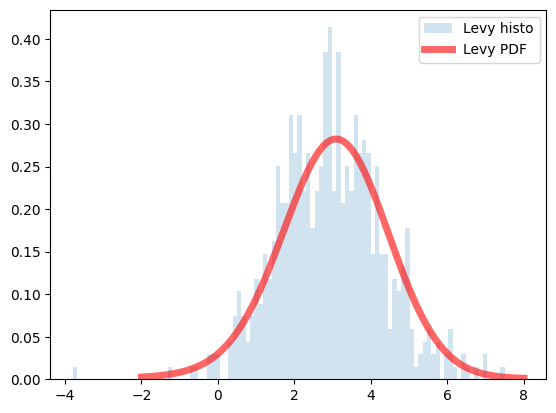

In [30]:
# parametros iniciales
miu = 3.0
levy_exponent = 1.9
beta = -0.5
resolution = 600
aux_domain = np.linspace(miu-5, miu+5, resolution)

# crear valores para la curva
levy_pdf = np.array([levy_stable.pdf(i, alpha=levy_exponent, beta=beta, loc=miu) for i in aux_domain])

# obtener valores aleatorios de distribucion tipo levy
r = levy_stable.rvs(alpha=levy_exponent, beta=beta, loc=miu, size=resolution)

# crear figura con matplotlib
figure, ax = plt.subplots(1, 1)

# agregar histograma a la figura
ax.hist(r, bins=100, density=True, histtype='stepfilled', alpha=0.2, label='Levy histo')

# agregar curva a la figura
ax.plot(aux_domain, levy_pdf, 'r-', lw=5, alpha=0.6, label='Levy PDF')

# colocar las etiquetas en el mejor lugar disponible
ax.legend(loc='best')

# mostrar grafico de comparacion
plt.show()

## Actividad 3 - Lévy flight - Vec2d - 1 Trayectoria

In [6]:
# parametros iniciales
n_steps = 1000
start_position = (0, 0)
speed = 6
velocity = Vec2d(speed, 0)
levy_exponent = 1.5
beta = 0

# crear dataframe inicial y agregar posicion inicial
levy_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
temporal_df = pd.DataFrame([{'x_pos': start_position[0], 'y_pos': start_position[1]}])

levy_df = pd.concat([levy_df, temporal_df], ignore_index=True)

# definir contador de pasos recorridos
steps_counter = 0

# definir contador de posiciones dentro del dataframe
position = 0

# iterar mientras el contador de pasos sea menor al numero de pasos por recorrer
while steps_counter < n_steps:
  # calcular pasos restantes
  remaining_steps = n_steps - steps_counter
  step_size = levy_stable.rvs(alpha=levy_exponent, beta=beta)
  # obtener el valor absoluto del paso
  step_size = abs(step_size)
  # si la cantidad de pasos obtenida de forma aleatoria es mayor a los pasos restantes
  # entonces los pasos a recorrer seran los pasos restantes
  if step_size > remaining_steps:
    step_size = remaining_steps

  turn_angle = np.random.uniform(0, 2*np.pi)
  velocity = velocity.rotated(turn_angle)
  # crear dataframe temporal para almacenar la posicion calculada,
  # los valores obtenidos se multiplican por la numero de pasos obtenidos de forma aleatoria
  temporal_df = pd.DataFrame([{
      'x_pos': levy_df.x_pos[position] + (velocity.x * step_size),
      'y_pos': levy_df.y_pos[position] + (velocity.y * step_size)
  }])
  # agregar dataframe con nueva posicion al dataframe de la trayectoria
  levy_df = pd.concat([levy_df, temporal_df], ignore_index=True)

  # el contador de pasos incrementa en base a los pasos recorridos
  steps_counter += step_size
  # incremento de 1 a controlador de posicion
  position += 1


# print(f'Dataframe final: {levy_df}, contador de pasos recorridos: {steps_counter}')

# crear figura 3D con los valores calculados en la iteracion
figure_levy_3d = go.Figure()
figure_levy_3d.add_trace(go.Scatter3d(
    x=levy_df.x_pos,
    y=levy_df.y_pos,
    z=np.linspace(0, position, position),
    marker=dict(size=1),
    name='Levy Flight 3D'
))
figure_levy_3d.update_layout(
    title_text='Levy Flight in 3D',
    autosize=False,
    width=800,
    height=800
)

# mostrar figura
figure_levy_3d.show()


## Actividad 4 - Correlated Random Walk - Vec2d - N Trayectorias

In [19]:
# parametros iniciales
resolution = 200
n_traj = 3
crw_exponents = np.linspace(0.2, 0.95, n_traj)

# crear dataframe para almacenar las trayectorias
trajectories = pd.DataFrame(columns=['trajectory_index', 'x_pos', 'y_pos'])

# iterar para calcular las N trayectorias
for trajectory_index in range(n_traj):
  crw_exponent = crw_exponents[trajectory_index]
  # print(crw_exponent)
  # calculo de giros aleatorios
  turn_angles = wrapcauchy.rvs(c=crw_exponent, size=resolution)
  speed = 5
  start_position = (0, 0)
  velocity = Vec2d(speed, 0)

  # crear dataframe para almacenar la trayectoria
  trajectory = pd.DataFrame(columns=['trajectory_index', 'x_pos', 'y_pos'])
  # crear dataframe temporal para almacenar las posiciones iniciales
  temporal_df = pd.DataFrame([{'trajectory_index': trajectory_index, 'x_pos': start_position[0], 'y_pos': start_position[1]}])
  trajectory = pd.concat([trajectory, temporal_df], ignore_index=True)
  for i in range(1, resolution):
    turn_angle = turn_angles[i]
    velocity = velocity.rotated(turn_angle)
    # crear dataframe temporalpara agregar la posicion al dataframe de la trayectoria
    temporal_df = pd.DataFrame([{
        'trajectory_index': trajectory_index,
        'x_pos': trajectory.x_pos[i-1] + velocity.x,
        'y_pos': trajectory.y_pos[i-1] + velocity.y
    }])
    # concatener dataframe con posicion al dataframe de la trayectoria
    trajectory = pd.concat([trajectory, temporal_df], ignore_index=True)

  # concatenar trayectoria al dataframe de trayectorias
  trajectories = pd.concat([trajectories, trajectory], ignore_index=True)


print(trajectories.head(10))



  trajectory_index      x_pos      y_pos
0                0          0          0
1                0  -4.285895  -2.575094
2                0  -5.997654  -7.272953
3                0  -1.715423  -9.854134
4                0   2.146984  -6.678946
5                0   4.967589 -10.807407
6                0   1.086259   -7.65538
7                0  -3.907657  -7.901969
8                0  -5.777678 -12.539104
9                0 -10.753345 -13.031789
